In [18]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from scipy.signal import convolve2d
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True,
    do_psf=False,
)
sources_in_tpf = eleanor.mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2
x, y = np.meshgrid(range(-58, 59), range(-58, 59)) 
nstars = len(xc)

/Users/adityasengupta/research/pals/photometry/eleanor/eleanor/targetdata.py:511: UserWarning: WARNING: Making a TPF smaller than (13,13) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (13,13) may provide inadequate results.')


In [47]:
prf = eleanor.make_prf_from_source(star)

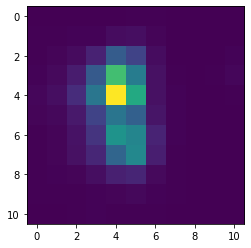

In [48]:
plt.imshow(tpfs[0])

In [62]:
tpfs_t = [torch.tensor(d) for d in tpfs.astype(np.float32)]
errs_t = [torch.tensor(e) for e in errs.astype(np.float32)]
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - tpfs_t[i]) ** 2, errs_t[i]))

In [63]:
gaussian_oversampled = eleanor.models.Gaussian(
    shape=(99,99),
    col_ref=0,
    row_ref=0,
    xc=9*xc,
    yc=9*yc,
    bkg0 = np.max(bkg0),
    loss = nll,
    source = star
)

def mean_with_prf(fluxes, xshift, yshift, bkg, optpars):
    mean99 = convolve2d(gaussian_oversampled.mean(fluxes, xshift, yshift, bkg, optpars).detach().numpy(), prf, mode='same')
    return torch.tensor(np.array([[np.mean(mean99[9*i:9*(i+1), 9*j:9*(j+1)]) for i in range(11)] for j in range(11)]))

In [71]:
def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = mean_with_prf(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    return loss.detach().numpy()
    gradient = tgrad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [74]:
loss_and_grad_fn(gaussian_oversampled.get_default_par(tpfs[0]), 0)

array(5.62453257e+09)

In [77]:
sopt.minimize(loss_and_grad_fn, gaussian_oversampled.get_default_par(tpfs[0]), 0, method='TNC', tol=1e-4)

/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/scipy-1.5.2-py3.8-macosx-10.9-x86_64.egg/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/scipy-1.5.2-py3.8-macosx-10.9-x86_64.egg/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/scipy-1.5.2-py3.8-macosx-10.9-x86_64.egg/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1


KeyboardInterrupt: 

In [80]:
p = gaussian_oversampled.get_default_par(tpfs[0])
p[-1] = 0
p[-3] = 0

In [81]:
loss_and_grad_fn(p, 0)

array(5.71480146e+09)